Download labeling from GitHub - https://github.com/tzutalin/labelImg


`!pip install pyqt5`

`!pip install lxml`


Installation guide - https://github.com/heartexlabs/labelImg#installation

Run this command in the terminal

`pyrcc5 -o libs/resources.py resources.qrc`

In [20]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.retinanet import RetinaNet_ResNet50_FPN_Weights

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Number of classes including background
num_classes = 91 

# Load a pre-trained model
model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True, num_classes=num_classes)

model.to(device)

# Continue with your code...(Origional numbers)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)


class YOLODataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform if transform else transforms.ToTensor()
        self.imgs = list(sorted(os.listdir(os.path.join(root_dir, "images"))))
        self.labels = list(sorted(os.listdir(os.path.join(root_dir, "labels"))))

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, "images", self.imgs[idx])
        label_path = os.path.join(self.root_dir, "labels", self.labels[idx])

        img = Image.open(img_path).convert("RGB")
        img_width, img_height = img.size

        # Apply transformation after getting original size
        img = self.transform(img)

        # Read YOLO label file
        with open(label_path, "r") as file:
            lines = file.read().splitlines()

        boxes = []
        labels = []
        for line in lines:
            class_id, x_center, y_center, width, height = map(float, line.split())
            labels.append(int(class_id))

            x_min = img_width * (x_center - width / 2)
            y_min = img_height * (y_center - height / 2)
            x_max = img_width * (x_center + width / 2)
            y_max = img_height * (y_center + height / 2)
            boxes.append([x_min, y_min, x_max, y_max])

        target = {}
        target['boxes'] = torch.tensor(boxes, dtype=torch.float32)
        target['labels'] = torch.tensor(labels, dtype=torch.int64)

        return img, target

# Define your own paths here
train_dataset = YOLODataset("data/train set")
valid_dataset = YOLODataset("data/validation set")

def collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]

    return images, targets

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)


c:\Users\dalto\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\dalto\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
model.train()
num_epochs = 25
model = model.to(device)
for epoch in range(num_epochs):
    for i, (images, targets) in enumerate(train_dataloader):
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]


        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch: {epoch + 1}, Loss: {losses.item()}")

Epoch: 1, Loss: 0.3887019157409668
Epoch: 2, Loss: 0.2323489487171173
Epoch: 3, Loss: 0.26616835594177246
Epoch: 4, Loss: 0.1496686041355133
Epoch: 5, Loss: 0.1842370629310608
Epoch: 6, Loss: 0.15036752820014954
Epoch: 7, Loss: 0.15598805248737335
Epoch: 8, Loss: 0.12738914787769318
Epoch: 9, Loss: 0.128993958234787
Epoch: 10, Loss: 0.209634929895401
Epoch: 11, Loss: 0.13656605780124664
Epoch: 12, Loss: 0.1266290843486786
Epoch: 13, Loss: 0.0728553980588913
Epoch: 14, Loss: 0.14549945294857025
Epoch: 15, Loss: 0.1275947391986847
Epoch: 16, Loss: 0.0698789432644844
Epoch: 17, Loss: 0.10647433996200562
Epoch: 18, Loss: 0.07659226655960083
Epoch: 19, Loss: 0.057783499360084534
Epoch: 20, Loss: 0.10728880763053894
Epoch: 21, Loss: 0.10319004952907562
Epoch: 22, Loss: 0.09872713685035706
Epoch: 23, Loss: 0.06278043240308762
Epoch: 24, Loss: 0.09239321202039719
Epoch: 25, Loss: 0.10224539041519165


In [3]:
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

True
True


In [24]:
from torchvision import transforms
from PIL import Image

# After training your model...

# # Save your trained model
# torch.save(model.state_dict(), "trained_models/model_weights.pth")

# # Load your trained model
# model.load_state_dict(torch.load("trained_models/model_weights.pth"))


model.eval()

# Define transform
transform = transforms.Compose([transforms.ToTensor()])

# Load a new image
image_path = "data/test set/images/2023-07-17_17-57.png"  # replace with your image path
image = Image.open(image_path).convert("RGB")
image = transform(image)
image = image.unsqueeze(0).to(device)  # add batch dimension and move to device

# Perform inference
with torch.no_grad():
    prediction = model(image)

# prediction[0] is a dict with keys 'boxes', 'labels', and 'scores'
boxes = prediction[0]['boxes']
labels = prediction[0]['labels']
scores = prediction[0]['scores']

# Filter out predictions with low confidence
lower_confidence_threshold = 0.5
upper_confidence_threshold = 0.99
valid_indices = (scores >= lower_confidence_threshold) & (scores <= upper_confidence_threshold)

boxes = boxes[valid_indices]
labels = labels[valid_indices]
scores = scores[valid_indices]
# Print out the predictions
for label, score, box in zip(labels, scores, boxes):
    print(f"Label: {label}, Score: {score}, Box: {box}")

Label: 1, Score: 0.9891852140426636, Box: tensor([245.8387, 460.9898, 280.0133, 489.5811], device='cuda:0')
Label: 1, Score: 0.9868565201759338, Box: tensor([512.8687, 446.0919, 553.1417, 472.9952], device='cuda:0')
Label: 1, Score: 0.9865866899490356, Box: tensor([351.5850, 487.6205, 390.5663, 516.4791], device='cuda:0')
Label: 1, Score: 0.985577404499054, Box: tensor([308.5471, 465.6445, 362.6750, 491.6342], device='cuda:0')
Label: 1, Score: 0.9814866185188293, Box: tensor([483.6607, 365.6733, 524.8137, 385.5093], device='cuda:0')
Label: 1, Score: 0.97698575258255, Box: tensor([436.4875, 463.9547, 478.0086, 488.9688], device='cuda:0')
Label: 1, Score: 0.9738742709159851, Box: tensor([  0.9035, 571.2590,  32.5573, 603.4775], device='cuda:0')
Label: 1, Score: 0.9678489565849304, Box: tensor([510.9846, 687.8817, 578.2390, 720.0000], device='cuda:0')
Label: 1, Score: 0.9478092789649963, Box: tensor([522.9604, 346.4567, 565.0618, 364.0654], device='cuda:0')
Label: 1, Score: 0.674930691719

Box coordinates: [245.83868 460.98984 280.0133  489.5811 ]
Label: 1, Score: 0.9891852140426636
Box coordinates: [512.8687  446.09186 553.1417  472.9952 ]
Label: 1, Score: 0.9868565201759338
Box coordinates: [351.58502 487.62048 390.56628 516.4791 ]
Label: 1, Score: 0.9865866899490356
Box coordinates: [308.54706 465.6445  362.675   491.63425]
Label: 1, Score: 0.985577404499054
Box coordinates: [483.66068 365.67328 524.8137  385.50928]
Label: 1, Score: 0.9814866185188293
Box coordinates: [436.48755 463.95474 478.0086  488.96878]
Label: 1, Score: 0.97698575258255
Box coordinates: [  0.9034998 571.259      32.557327  603.47754  ]
Label: 1, Score: 0.9738742709159851
Box coordinates: [510.98462 687.8817  578.23895 720.     ]
Label: 1, Score: 0.9678489565849304
Box coordinates: [522.9604  346.45673 565.0618  364.0654 ]
Label: 1, Score: 0.9478092789649963
Box coordinates: [1203.3524   481.46732 1278.0371   519.34546]
Label: 1, Score: 0.6749306917190552


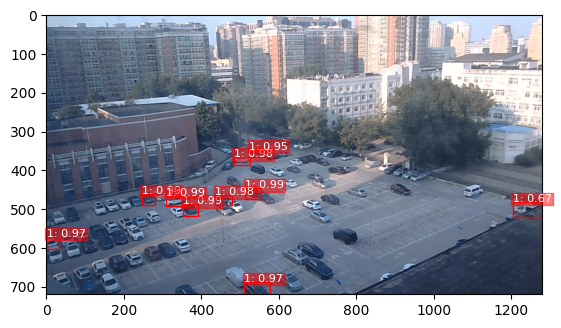

In [25]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load the image again, but this time without transforming it into a tensor
image = Image.open(image_path)

# Create a new figure and plot the image
fig, ax = plt.subplots(1)
ax.imshow(image)

# For each box...
for box, label, score in zip(boxes, labels, scores):
    # Move the box to CPU and convert it to a list
    box = box.cpu().numpy()

    print(f'Box coordinates: {box}')  # Print the box coordinates
    print(f'Label: {label}, Score: {score}')  # Print the label and score

    # Create a Rectangle patch
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    # Add label and score text
    plt.text(box[0], box[1], f'{label}: {score:.2f}', color='white', fontsize=8,
                 bbox=dict(facecolor='r', edgecolor='r', pad=1, alpha=0.5))

plt.show()
